<a href="https://colab.research.google.com/github/shree180103/dcgan_mnist/blob/main/dcgan_with_fid_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

In [2]:
torch.cuda.is_available()

True

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class Discriminator(nn.Module):
  def __init__(self,input_shape:int):
    super().__init__()
    self.conv_layer=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=0,bias=False),
        nn.Sigmoid()


    )

  def forward(self,x):
    return self.conv_layer(x)


In [5]:
class Generator(nn.Module):
  def __init__(self,z_dim:int,img_channels):
    super().__init__()
    self.trans_conv_layer=nn.Sequential(
        nn.ConvTranspose2d(in_channels=z_dim,out_channels=512,kernel_size=4,stride=1,padding=0,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=64,out_channels=img_channels,kernel_size=4,stride=2,padding=1,bias=False),
        nn.Tanh()


    )

  def forward(self,x):
    return self.trans_conv_layer(x)




In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"
n_c=3

gen=Generator(z_dim=100,img_channels=n_c).to(device)
gen.apply(weights_init)

disc=Discriminator(input_shape=n_c).to(device)
disc.apply(weights_init)


Discriminator(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [7]:
device

'cuda'

In [8]:
# training params
batch_size=128
lr=0.0002
z_dim=100
img_size=64
n_c=3

transform=transforms.Compose(transforms=[transforms.ToTensor(),
                                         transforms.Resize((64,64)),
                                         transforms.CenterCrop(img_size),
                                         transforms.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)])])
dataset=datasets.ImageFolder(root="celeb",transform=transform)
data_loader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)



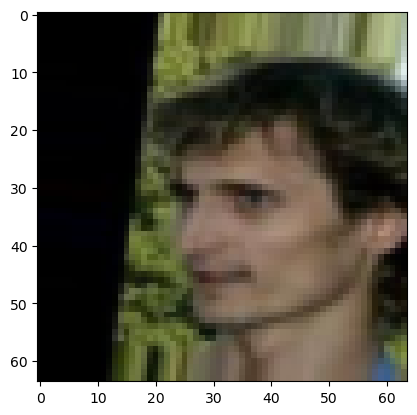

In [9]:
image,label=next(iter(data_loader))
import matplotlib.pyplot as plt
plt.imshow((image[0]*0.5+0.5).permute(1,2,0))
plt.show()

In [10]:
loss_fn=nn.BCELoss()
optimizer_disc=torch.optim.Adam(params=disc.parameters(),lr=lr,betas=(0.5,0.999))
optimizer_gen=torch.optim.Adam(params=gen.parameters(),lr=lr,betas=(0.5,0.999))

In [11]:
writer_fake=SummaryWriter("logs/GAN_MNIST/fake")

writer_real=SummaryWriter("logs/GAN_MNIST/real")

step = 0

fixed_noise = torch.randn(size=(64,z_dim,1,1))

In [12]:
# z=torch.rand(size=(1,100,1,1))
# z.shape

In [13]:
# img,label=next(iter(data_loader))
# img.shape

In [14]:
!pip install torchinfo

In [15]:
from torchinfo import summary

summary(disc,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 1, 1]              --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           3,072
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,072
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,288
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
│    └─Conv2d: 2-9                       [1, 512, 4, 4]            2,097,152
│    └─BatchNorm2d: 2-10                 [1, 512, 4, 4]            1,024
│    └─LeakyReLU: 2-11                   [1, 512, 4, 4]     

In [16]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)


In [17]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)

In [18]:
summary(gen,input_size=[1,100,1,1])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─ConvTranspose2d: 2-1              [1, 512, 4, 4]            819,200
│    └─BatchNorm2d: 2-2                  [1, 512, 4, 4]            1,024
│    └─ReLU: 2-3                         [1, 512, 4, 4]            --
│    └─ConvTranspose2d: 2-4              [1, 256, 8, 8]            2,097,152
│    └─BatchNorm2d: 2-5                  [1, 256, 8, 8]            512
│    └─ReLU: 2-6                         [1, 256, 8, 8]            --
│    └─ConvTranspose2d: 2-7              [1, 128, 16, 16]          524,288
│    └─BatchNorm2d: 2-8                  [1, 128, 16, 16]          256
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─ConvTranspose2d: 2-10             [1, 64, 32, 32]           131,072
│    └─BatchNorm2d: 2-11                 [1, 64, 32, 32]  

In [19]:
# gen.eval()
# with torch.inference_mode():
#   print(gen(z.to('cuda')).shape)

In [20]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import inception_v3
from torchvision.models import Inception_V3_Weights
import scipy
import numpy as np

In [21]:
from tqdm.auto import tqdm

epochs=10
LOSS_D=[]
LOSS_G=[]
fid_scores=[]

for epoch in tqdm(range(epochs)):
  for batch_idx,(x,_) in enumerate(data_loader):
    z=torch.randn(size=(batch_size,100,1,1),device=device)

    ## traing the discriminator

    disc.zero_grad()
    disc_real=disc(x.to(device)).reshape(-1)
    loss_disc_real=loss_fn(disc_real,torch.ones_like(disc_real))
    loss_disc_real.backward()


    fake=gen(z.to(device))

    
    disc_fake=disc(fake.detach().to(device)).reshape(-1)
    loss_disc_fake=loss_fn(disc_fake,torch.zeros_like(disc_fake))
    loss_disc_fake.backward()

    loss_disc=loss_disc_fake+loss_disc_real
    LOSS_D.append(loss_disc.item())

    optimizer_disc.step()

    #training generator
    gen.zero_grad()

    fool_logits=disc(fake.to(device)).reshape(-1)
    loss_gen=loss_fn(fool_logits,torch.ones_like(fool_logits))
    LOSS_G.append(loss_gen.item())

    loss_gen.backward()

    optimizer_gen.step()

    if batch_idx== 0:
           
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(data_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise.to(device)).detach()
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(x[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1











  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [0/10] Batch 0/1583                   Loss D: 1.8707, loss G: 3.5132
Epoch [1/10] Batch 0/1583                   Loss D: 0.8184, loss G: 3.4865
Epoch [2/10] Batch 0/1583                   Loss D: 0.7263, loss G: 4.5816
Epoch [3/10] Batch 0/1583                   Loss D: 0.4883, loss G: 1.5819
Epoch [4/10] Batch 0/1583                   Loss D: 0.6502, loss G: 1.9001
Epoch [5/10] Batch 0/1583                   Loss D: 0.6286, loss G: 2.0956
Epoch [6/10] Batch 0/1583                   Loss D: 0.4795, loss G: 3.2346
Epoch [7/10] Batch 0/1583                   Loss D: 0.3615, loss G: 2.4979
Epoch [8/10] Batch 0/1583                   Loss D: 0.3927, loss G: 2.1589
Epoch [9/10] Batch 0/1583                   Loss D: 0.6431, loss G: 2.9723


In [22]:
noise=torch.rand(size=(batch_size,z_dim,1,1)).to(device)
gen_img=gen(noise)

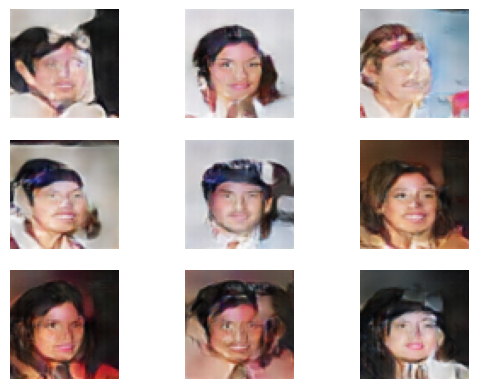

In [23]:
with torch.inference_mode():
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow((gen_img[i]*0.5+0.5).permute(1,2,0).cpu())
    plt.axis(False)

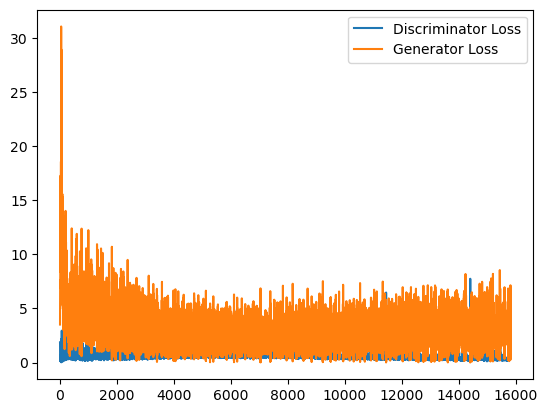

In [24]:
plt.plot(LOSS_D,label="Discriminator Loss")
plt.plot(LOSS_G,label="Generator Loss")
plt.legend()
plt.show()

In [25]:
class PartialInceptionNetwork(nn.Module):
  def __init__(self):
    super(PartialInceptionNetwork, self).__init__()
    self.inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT)  #initializing pretrsined model
    self.inception_model.Mixed_7c.register_forward_hook(self.output_hook)
    self.output = None

  def output_hook(self, module, input, output):
    self.mixed_7c_output = output

  def forward(self, x):
    assert x.shape[1:] == (3, 299, 299), "Input shape should be (batch_size, 3, 299, 299)"
    self.inception_model(x)
    activations = self.mixed_7c_output
    activations = F.adaptive_avg_pool2d(activations, (1, 1))
    activations = activations.view(x.shape[0],2048)
    return activations

net=PartialInceptionNetwork().to(device)

def fid_score(real_images, gen_images,batch_size):
  real_activations = []
  gen_activations = []
  num_steps=int(math.ceil(float(len(real_images))/float(batch_size)))
  for i in range(num_steps):
    s = i * batch_size
    e=(1+i) * batch_size

    mini_real_batch=real_images[s:e]
    mini_gen_batch=gen_images[s:e]

    batch_real=Variable(mini_real_batch).to(device)
    batch_gen=Variable(mini_gen_batch).to(device)

  features_real=net(batch_real)
  features_gen=net(batch_gen)

  real_activations.append(features_real)
  gen_activations.append(features_gen)

  features_real=torch.cat(real_activations,0)
  features_gen=torch.cat(gen_activations,0)

  xr=features_real.cpu().detach().numpy()
  xg=features_gen.cpu().detach().numpy()

  u1=np.mean(xr,axis=0)
  u2=np.mean(xg,axis=0)
  s1=np.cov(xr,rowvar=False)
  s2=np.cov(xg,rowvar=False)

  diff=u1-u2
  diff_squared=diff.dot(diff)

  prod=np.dot(s1,s2)

  sqrt_prod,_=scipy.linalg.sqrtm(prod,disp=False)

  if np.iscomplexobj(sqrt_prod):
      sqrt_prod=sqrt_prod.real

  prod_tr=np.trace(sqrt_prod)

  fid_score=diff_squared+np.trace(s1)+np.trace(s2)-2*prod_tr

  return fid_score

In [29]:
x,label=next(iter(data_loader))
x=x[0:32]
gen_img=gen_img[0:32]
gen_images=gen_img.view(-1,1,64,64)
gen_images=gen_images.repeat(1,3,1,1)
gen_res_images=F.interpolate(gen_images,size=(299,299))
real_images = x.view(-1, 1, 64, 64) # Reshape real_images similar to gen_images
real_images = real_images.repeat(1, 3, 1, 1) # Repeat channels for real_images
real_images = F.interpolate(real_images, size=(299, 299)) # Resize 
net.eval()  # Set the model to evaluation mode
fid = fid_score(real_images, gen_res_images,32)
print(fid)

149.1244845053551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


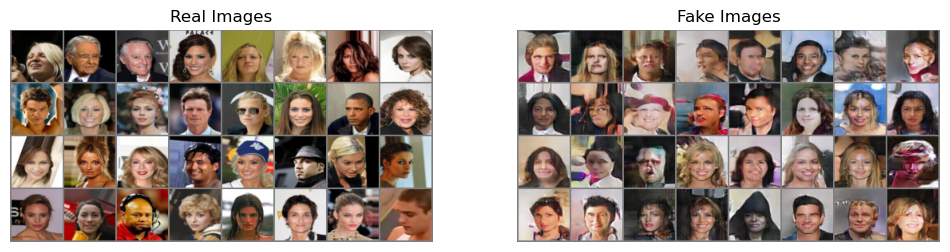

In [35]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to get real images from your dataset
def get_real_images(data_loader):
    real_images,_ = next(iter(data_loader))
    return real_images[:32]

# Function to generate fake images from the generator
def generate_fake_images(gen, num_images, noise_dim):
    noise = torch.randn(num_images, noise_dim).to(device)  # Shape: [num_images, noise_dim]
    noise = noise.view(num_images, noise_dim, 1, 1)  # Reshape to [num_images, noise_dim, 1, 1]
    with torch.no_grad():
        fake_images = gen(noise)  # Pass reshaped noise to the generator
    return fake_images

# Display images
def show_images(real_images, fake_images):


    

    # Create a grid of images
    real_grid = make_grid(real_images, nrow=8)
    fake_grid = make_grid(fake_images, nrow=8)

    plt.figure(figsize=(12, 6))

    # Plot real images
    plt.subplot(1, 2, 1)
    plt.title("Real Images")
    plt.imshow((real_grid*0.5+0.5).permute(1, 2, 0))
    plt.axis('off')

    # Plot fake images
    plt.subplot(1, 2, 2)
    plt.title("Fake Images")
    plt.imshow((fake_grid*0.5+0.5).cpu().permute(1, 2, 0))
    plt.axis('off')

    plt.show()

# Hyperparameters
batch_size = 32
noise_dim = 100

# Assume you have a data loader for real images
# Example: data_loader = DataLoader(your_dataset, batch_size=batch_size, shuffle=True)

# Get real images
real_images = get_real_images(data_loader)

# Generate fake images
num_images = batch_size  # Same as the batch size for consistency
fake_images = generate_fake_images(gen, num_images, noise_dim)

# Show images
show_images(real_images, fake_images)
